# Covid19 tweets classification

---

**Summary** : 

This notebook aims to building three-way polarity (positive, negative, neutral) classification system for tweets. 

We'll use the external dataset of Coronavisur tweets, pre-trained word embeddings vectors GLOVE and Keras Sequential model to create an engine capable to classify the tweet as positive, negative or neutral.

**Data source** : 

The dataset is publicy available on Kaggle : 
https://www.kaggle.com/datatattle/covid-19-nlp-text-classification

The dataset includes two files : 
- Corona_NLP_train.csv : This file contains ~41000 raw tweets, along with their polarity labels and some tweets characteristics such as location, time, user id. We'll use this file to train our classifiers.
- Corona_NLP_test.csv : In the same format as the training csv, the file contains a smaller set of tweets, ~4000. We'll use it to test the predictions of our classifiers. 


**Pre trained embeddings source** : 

Glove pre-trained embeddings vectors are publicly available : 
http://nlp.stanford.edu/data/glove.twitter.27B.zip

We use vectors with 25 dimensions trained on Twitter data. 

**Notebook structure** 

This Notebook has 4 main parts:
- Exploratory Data Analysis
- Data Preparation
- Model Creation
- Model Evaluation 

# 1.Exploratory Data Analysis

#### 1.0 Paths

In [3]:
# The dataset is available here : https://www.kaggle.com/datatattle/covid-19-nlp-text-classification

train_path = "data/Corona_NLP_train.csv"
test_path = "data/Corona_NLP_test.csv"

# Glove pre-trained embeddings are available here : http://nlp.stanford.edu/data/glove.twitter.27B.zip
# We use vectors with 25 dimensions trained on Twitter data

GLOVE_PATH = 'embeddings/glove.twitter.27B.25d.txt'


#### 1.1 Setup

In [ ]:
import numpy as np
from numpy import mean
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import re

from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

from sklearn.model_selection import train_test_split
from sklearn import metrics

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
nltk.download('stopwords')
nltk.download('wordnet')

import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

#### 1.2. Load the dataset : Coronavirus tweets NLP - Text Classification

In [10]:
train_df = pd.read_csv(train_path, engine='python')
test_df = pd.read_csv(test_path, engine='python')

train_df = train_df
test_df = test_df

In [335]:
print(train_df.shape)
print(test_df.shape)

(41157, 6)
(3798, 6)


#### 1.3. Explore the dataset

In [315]:
train_df.columns

Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
       'Sentiment'],
      dtype='object')

In [316]:
train_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [317]:
print('All used target sentiment labels (Train data)  : ', train_df['Sentiment'].unique())
print('OriginalTweet number (Train data): ', train_df['OriginalTweet'].count(), '\n')
print('All used target sentiment labels (Test data)  : ', test_df['Sentiment'].unique())
print('OriginalTweet number (Test data): ', test_df['OriginalTweet'].count())

All used target sentiment labels (Train data)  :  ['Neutral' 'Positive' 'Extremely Negative' 'Negative' 'Extremely Positive']
OriginalTweet number (Train data):  41157 

All used target sentiment labels (Test data)  :  ['Extremely Negative' 'Positive' 'Extremely Positive' 'Negative' 'Neutral']
OriginalTweet number (Test data):  3798


**Target data** : 'Sentiment' column containing sentiment tarhet labels. 

**Train data** : 'OriginalTweet' column containg the raw text of the tweets. 

We will omit tweet's and user's metadata ( i.e. columns :  'UserName', 'ScreenName', 'Location' and 'TweetAt') and concentrate ony on raw data analysis. 

In [318]:
# Check for null values -> no null values found

train_df[['Sentiment', 'OriginalTweet']].info()
test_df[['Sentiment', 'OriginalTweet']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 2 columns):
Sentiment        41157 non-null object
OriginalTweet    41157 non-null object
dtypes: object(2)
memory usage: 643.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 2 columns):
Sentiment        3798 non-null object
OriginalTweet    3798 non-null object
dtypes: object(2)
memory usage: 59.5+ KB


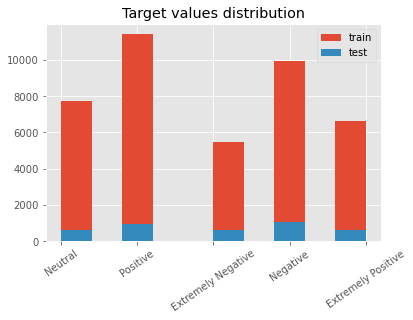

In [11]:
# Check target values distribution -> 

#  Target values distributin is not well balanced.
# Besides, the target values 'Extremely negative' and 'Extremely positive' should be merged with 
# 'Negative' and 'Positive' class in order to perform 3-way polarity classification. 

plt.hist(train_df['Sentiment'], label = 'train')
plt.hist(test_df['Sentiment'], label = 'test')

plt.xticks(rotation = 35)
plt.legend(loc = 'upper right')
plt.title(label = 'Target values distribution')
plt.show()

In [319]:
# Explore tweets raw text  -> 
# We will nedd to clean hashtags, links, mentions

for i in range(20):
    print(train_df['Sentiment'][i])
    print(train_df['OriginalTweet'][i], '\n-------------')

Neutral
@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8 
-------------
Positive
advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order 
-------------
Positive
Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P 
-------------
Positive





#COVID19france #COVID_19 #COVID19 #coronavirus #confinement #Confinementotal #ConfinementGeneral https://t.co/zrlG0Z520j 
-------------
Extremely Negative




#CoronavirusFrance #restezchezvous #StayAtHome #confinement https://t.co/usmuaLq72n 
-------------
Positive
As news of the regionВ’s first confirmed COVID-19 case came out of Sullivan County last week, people flocked to area stores to purchase cleaning supplies, hand saniti

In [320]:
tweets_len = np.array([len(x) for x in train_df['OriginalTweet']])

mean_len = tweets_len.mean()
median_len = np.median(tweets_len)
perc_25 = np.percentile(tweets_len, 25)
perc_75 = np.percentile(tweets_len, 75)
min_len = tweets_len.min()
max_len = tweets_len.max()

print('Mean tweets length : ', mean_len)
print('Median tweets length : ', median_len)

print('Percentile 25% :', perc_25)
print('Percentile 75% :', perc_75)

print('Tweets len min :', min_len)
print('Tweets len max :', max_len)

Mean tweets length :  204.20016036154237
Median tweets length :  215.0
Percentile 25% : 151.0
Percentile 75% : 259.0
Tweets len min : 11
Tweets len max : 355


#####  Conclusion : 

- Target values are not well distributed. 
- No malformed features detected. 
- The tweet's length is rather stable, around 200 caracters, without a lot of outliers. 

Next section contains the data preparation part. We will clean the raw tweets, tokenize them and load the pretrained word embeddings. 

# 2. Dataset Preparation

#### 2.1 Dataset cleaning

In [329]:
# Functions for target labels mapping and raw text cleaning

def map_labels(sentiment :str) -> int:
    ''' map target labels '''
    
    if sentiment in {"Extremely Positive", "Positive"}:
        return 1
    elif sentiment in  {"Extremely Negative", "Negative"}:
        return 2
    else:
        return 0

def clean_string(text : str) -> str:
    ''' clean raw text'''
    
    # clean mentions
    text = re.sub(r'@\S+', " ", text)
    
    # clean mentions
    text = re.sub(r'\&\w+', " ", text)
    
    # clean urls
    text = re.sub(r'http\S+', " ", text)
    
    # clean hashtags
    text = re.sub(r'#\S+', " ", text)
    
    # clean digits
    text = re.sub(r'\d+', " ", text)
    
    # clean html tags
    text = re.sub(r'\\[rn]', " ", text)
    
    # lower
    text = text.lower()
    
    # clean punctuation
    text = re.sub(r'\W', " ", text)
    
    # clean whitespaces
    text = re.sub(r'\s+', " ", text)
    
    # clean stopwords
    text = text.split()
    text = [word for word in text if not word in set(stopwords.words('english'))]
    
    # convert to lemmas 
    lemmatizer = WordNetLemmatizer() 
    text = [lemmatizer.lemmatize(word) for word in text ]
    
    text = ' '.join(text)
    
    return text

In [336]:
# Apply target labels mapping

train_df['Sentiment'] = train_df['Sentiment'].apply(lambda x: int(map_labels(x)))
test_df['Sentiment'] = test_df['Sentiment'].apply(lambda x: int(map_labels(x)))

In [337]:
train_df[['OriginalTweet', 'Sentiment']]

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,0
1,advice Talk to your neighbours family to excha...,1
2,Coronavirus Australia: Woolworths to give elde...,1
3,My food stock is not the only one which is emp...,1
4,"Me, ready to go at supermarket during the #COV...",2
...,...,...
41152,Airline pilots offering to stock supermarket s...,0
41153,Response to complaint not provided citing COVI...,2
41154,You know itВ’s getting tough when @KameronWild...,1
41155,Is it wrong that the smell of hand sanitizer i...,0


In [338]:
# Perform text cleaning

train_df['OriginalTweet_clean'] = train_df['OriginalTweet'].progress_apply(lambda x: clean_string(x))
test_df['OriginalTweet_clean'] = test_df['OriginalTweet'].progress_apply(lambda x: clean_string(x))

  0%|          | 0/41157 [00:00<?, ?it/s]

  0%|          | 0/3798 [00:00<?, ?it/s]

In [339]:
train_df[['OriginalTweet_clean', 'Sentiment']]

,OriginalTweet_clean,Sentiment
0,,0
1,advice talk neighbour family exchange phone nu...,1
2,coronavirus australia woolworth give elderly d...,1
3,food stock one empty please panic enough food ...,1
4,ready go supermarket outbreak paranoid food st...,2
...,...,...
41152,airline pilot offering stock supermarket shelf...,0
41153,response complaint provided citing covid relat...,2
41154,know itв getting tough rationing toilet paper ...,1
41155,wrong smell hand sanitizer starting turn,0


In [342]:
for i in range(5):
    print('Original : ', train_df['OriginalTweet'][i])
    print('Cleaned : ', train_df['OriginalTweet_clean'][i])
    print('----')

Original :  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8
Cleaned :  
----
Original :  advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order
Cleaned :  advice talk neighbour family exchange phone number create contact list phone number neighbour school employer chemist gp set online shopping account po adequate supply regular med order
----
Original :  Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P
Cleaned :  coronavirus australia woolworth give elderly disabled dedicated shopping hour amid covid outbreak
----





#COVID19france #COVID_19 #COVID19 #coronavirus #confinement #Confinementotal #ConfinementGeneral https://t.co/zrlG0Z520j
Cleaned :  food stock o

In [355]:
# Define train, validation and test dataset

X = train_df.OriginalTweet_clean
y = train_df.Sentiment

X_test = test_df.OriginalTweet_clean
y_test = test_df.Sentiment

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify = y, random_state=42)

In [356]:
X_train = X_train.to_numpy()
X_val = X_val.to_numpy()
X_test = X_test.to_numpy()

In [357]:
y_train = keras.utils.to_categorical(y_train, 3)
y_val = keras.utils.to_categorical(y_val, 3)
y_test = keras.utils.to_categorical(y_test, 3)

In [358]:
print('X_train shape : ', X_train.shape)
print('y_train shape : ', y_train.shape)
print('\nX_val shape : ', X_val.shape)
print('y_val shape : ', y_val.shape)
print('\nX_test shape : ', X_test.shape)
print('y_test shape : ', y_test.shape)

X_train shape :  (32925,)
y_train shape :  (32925, 3)

X_val shape :  (8232,)
y_val shape :  (8232, 3)

X_test shape :  (3798,)
y_test shape :  (3798, 3)


#### 2.2 Dataset tokenization

In [38]:
def define_max_len(data):
    
    ''' Define the maximum sequence's length '''
    
    len_ = [len(x) for x in X_train]
    len_.sort(reverse = True)
    return len_[0]

def init_tokenizer(X_train : np.ndarray) -> (Tokenizer, int, dict, int):
    
    '''Initialize tokenizer, define the vocabulary size, dictionary with word index and maximum 
    sequence length'''
    
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(X_train)

    vocab_size = len(tokenizer.word_index) + 1 
    word_index = tokenizer.word_index
    maxlen = define_max_len(X_train)
    
    return tokenizer, vocab_size, word_index, maxlen

def tokenize(tokenizer : Tokenizer, data : np.ndarray, maxlen : int) -> np.ndarray: 
    
    ''' Tokenize the data and pad the sequences'''

    data = tokenizer.texts_to_sequences(data)
    data = pad_sequences(data, padding='post', maxlen=maxlen)
    
    return data

In [359]:
# Perform tokenization

tokenizer, vocab_size, word_index, maxlen = init_tokenizer(X_train)

X_train = tokenize(tokenizer, X_train, maxlen)
X_test = tokenize(tokenizer, X_test,maxlen)
X_val = tokenize(tokenizer, X_val, maxlen)

In [361]:
print("Maximum tweet length : ", maxlen)
print("Vocabulary size : ", vocab_size)

Maximum tweet length :  261
Vocabulary size :  26867


#### 2.3 Load pre trained word embeddings GLOVE

In order to handle the relatively small size of disposed dataset, we will use pre-trained word embeddings GLOVE to add 'meaning' to our vocabulary. We choosed the embeddings trained on twitter dataset, with 200 dimensions. 

We will then compare the results of our model trained with pre-trained embeddings and embeddings trained on the disposed dataset. 

In [176]:
# Functions to open pre-trained embeddings file and create embedding matrix

def load_embeddings (emb_path : str) -> dict: 
    ''' Load embeddings file'''
    
    embeddings_index = {}
    f = open(emb_path , encoding = 'UTF-8')
    
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    print(f'Found {len(embeddings_index)} word vectors.')
    
    return embeddings_index

def create_embeddings_matrix(embedding_index : dict, embedding_dim : int) ->dict: 
    '''Create embedding matrix'''

    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            
    return embedding_matrix

In [349]:
embedding_dim = 25

In [350]:
embedding_index = load_embeddings(GLOVE_PATH)

Found 1193515 word vectors.


In [362]:
embedding_matrix = create_embeddings_matrix(embedding_index, embedding_dim)

In [363]:
print("Length of the word index : ", len(word_index)) 
print("Shape of the embedding matrix : ",len(embedding_matrix))

Length of the word index :  26866
Shape of the embedding matrix :  26867


# 3. Model creation

In [209]:
def create_emb_layer(use_Glove : bool, vocab_size : int, maxlen : int, 
                     *args) -> layers: 
    if use_Glove :
        embedding_layer = layers.Embedding(input_dim = vocab_size,
                            output_dim = embedding_dim,
                            weights=[embedding_matrix],
                            input_length = maxlen,
                            trainable=False)
    else: 
        embedding_layer = layers.Embedding(input_dim = vocab_size, 
                               output_dim = 16, 
                               input_length = maxlen)
        
    return embedding_layer


def create_model (embedding_layer : layers) -> Sequential : 
    model = Sequential([
        embedding_layer, 
        layers.Dropout(0.4), 
        
        layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3),
        layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3), 
        layers.GlobalAveragePooling1D(),
        
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4), 
        layers.Dense(3, activation='softmax')
    ])

    model.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])
    model.summary()
    
    return model

In [364]:
# Create emb layer with and without using GLOVE pre trained embeddings

embedding_layer_use_Glove = create_emb_layer(True, vocab_size, maxlen, embedding_dim, embedding_matrix)
embedding_layer_not_Glove = create_emb_layer(False, vocab_size, maxlen)

model_use_Glove = create_model(embedding_layer_use_Glove)
model_not_Glove = create_model(embedding_layer_not_Glove)

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_38 (Embedding)     (None, 261, 25)           671675    
_________________________________________________________________
dropout_66 (Dropout)         (None, 261, 25)           0         
_________________________________________________________________
conv1d_39 (Conv1D)           (None, 85, 128)           22528     
_________________________________________________________________
conv1d_40 (Conv1D)           (None, 27, 128)           114816    
_________________________________________________________________
global_average_pooling1d_36  (None, 128)               0         
_________________________________________________________________
dense_71 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_67 (Dropout)         (None, 128)             

In [365]:
# Callbacks

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor = 0.2, patience = 3, min_lr = 0.0001)
es = EarlyStopping(monitor='val_acc', mode='max', verbose = 1, patience = 50)
mc_not_Glove = ModelCheckpoint(f'best_model_not_Glove.h5', monitor = 'val_acc', mode = 'max', verbose = 1, save_best_only = True)
mc_use_Glove = ModelCheckpoint(f'best_model_use_Glove.h5', monitor = 'val_acc', mode = 'max', verbose = 1, save_best_only = True)

In [366]:
# Train two models using pretrained embeddings and embeddings created during the model creation.  

BATCH_SIZE = 32
EPOCS = 10

history_use_Glove = model_use_Glove.fit(X_train, y_train,
                    epochs = EPOCS,
                    verbose = True,
                    validation_data = (X_val, y_val),
                    batch_size = BATCH_SIZE, callbacks = [reduce_lr, es, mc_use_Glove])

history_not_Glove = model_not_Glove.fit(X_train, y_train,
                    epochs = EPOCS,
                    verbose = True,
                    validation_data = (X_val, y_val),
                    batch_size = BATCH_SIZE, callbacks = [reduce_lr, es, mc_not_Glove])

Train on 32925 samples, validate on 8232 samples
Epoch 1/10
32864/32925 [============================>.] - ETA: 0s - loss: 0.9341 - acc: 0.5411- ETA: 3s - loss: 0.9395 - acc: - ETA: 3s - lo
Epoch 00001: val_acc improved from -inf to 0.61467, saving model to best_model_use_Glove.h5
32925/32925 [==============================] - 32s 969us/sample - loss: 0.9340 - acc: 0.5412 - val_loss: 0.8625 - val_acc: 0.6147
Epoch 2/10
32832/32925 [============================>.] - ETA: 0s - loss: 0.8900 - acc: 0.5812
Epoch 00002: val_acc did not improve from 0.61467
32925/32925 [==============================] - 29s 884us/sample - loss: 0.8899 - acc: 0.5812 - val_loss: 0.8611 - val_acc: 0.6109
Epoch 3/10
32896/32925 [============================>.] - ETA: 0s - loss: 0.8697 - acc: 0.5952
Epoch 00003: val_acc improved from 0.61467 to 0.63557, saving model to best_model_use_Glove.h5
32925/32925 [==============================] - 29s 885us/sample - loss: 0.8697 - acc: 0.5953 - val_loss: 0.8335 - val_acc: 

# 4. Model evaluation

In [186]:
def plot_history(history : keras.callbacks.History, title = ''):
    ''' Plot history of Keras model : accuracy, loss, validation accuracy and validation loss '''
        
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [ ]:
model_use_Glove = load_model('models/best_model_use_Glove.h5')
model_not_Glove = load_model('models/best_model_not_Glove.h5')

In [368]:
_, valid_acc_use_Glove = model_use_Glove.evaluate(X_val, y_val, verbose=0)
_, valid_acc_not_Glove = model_not_Glove.evaluate(X_val, y_val, verbose=0)

print('Validaiton accuracy with Glove embeddings used : ', valid_acc_use_Glove)
print('Validaiton accuracy with embeddings created during model training : ', valid_acc_not_Glove)

Validaiton accuracy with Glove embeddings used :  0.65415454
Validaiton accuracy with embeddings created during model training :  0.8402575


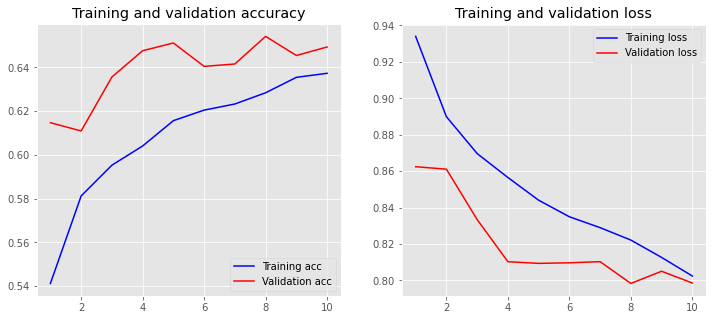

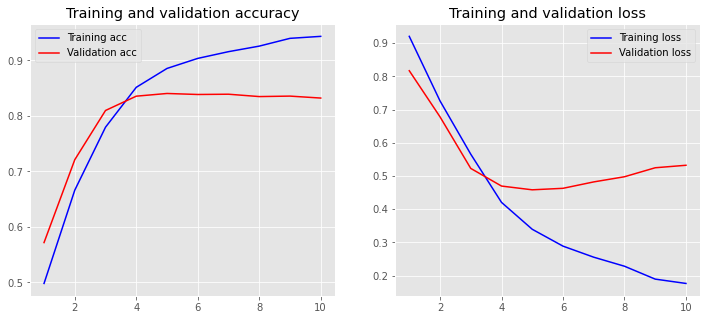

In [369]:
plot_history(history_use_Glove, 'Training results with Glove embeddings used')
plot_history(history_not_Glove, 'Training results without Glove embeddings used')

#### Conclusion : 

- The most performant model is the model with not pre-trained embeddings, but it's slightly overfitting. 
- The model with pre-trained embeddings does not overfit, but is not capable to attend high precision. 

We will choose as our best model the model with not pre trained embeddings. 


In [370]:
model, history  = model_not_Glove, history_not_Glove

#### 4.1. Predictions on the test data

In [371]:
_, val_acc = model.evaluate(X_test, y_test, verbose=0)
print('Validaiton accuracy on test sey : ', val_acc)

Validaiton accuracy on test sey :  0.8204318


              precision    recall  f1-score   support

           0       0.81      0.72      0.76       619
           1       0.82      0.87      0.84      1546
           2       0.83      0.81      0.82      1633

    accuracy                           0.82      3798
   macro avg       0.82      0.80      0.81      3798
weighted avg       0.82      0.82      0.82      3798



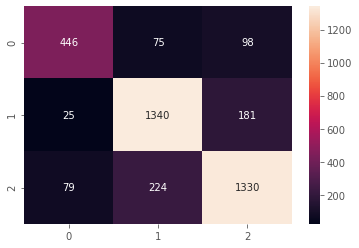

In [372]:
# Plot the confusion matrix 

pred = model.predict_classes(X_test)
y_val_arg = np.argmax(y_test, axis=1)
cm = metrics.confusion_matrix(y_val_arg, pred)
sns.heatmap(cm, annot=True, fmt = 'd')

print(metrics.classification_report(y_val_arg, pred))

##### 4.2. Visualize errors 

In [390]:
def display_errors(df : pd.DataFrame, X : np.ndarray, y : np.ndarray, y_pred : np.ndarray, true_val : int, false_val : int) -> None:
    show = 0
    
    target_labels = {0 : 'neutral', 1: 'positive', 2 : 'negative'}
    
    for i in range(len(X)):
        if  (y[i] == true_val) and  (y_pred[i] == false_val) and show < 3:
            print('True value : ', target_labels[true_val])
            print('False value : ', target_labels[false_val])
            print('\nCLEANED : \n', tokenizer.sequences_to_texts(X)[i])
            print('\nORIGINAL : \n', df['OriginalTweet'][i])
            print('-------------')
            
            show +=1

In [388]:
confused_values = [(1, 2), (2, 1)]

In [391]:
for value in confused_values: 
    true_val = value[0]
    false_val = value[1]
    
    display_errors(test_df, X_test, np.argmax(y_test, axis=1), pred, true_val, false_val)

True value :  positive
False value :  negative

CLEANED : 
 booked ticket event part package holiday offered alternative refund travel provider cancelled due check abta consumer q

ORIGINAL : 
 If you have booked a ticket to an event as part of a package holiday you will be offered an alternative or a refund by your travel provider, if it has been cancelled due to #Coronavirus.

Check ABTA's consumer Q&amp;A at: https://t.co/oUB4MNmrNA

#COVID19 https://t.co/kMHJehS2JH
-------------
True value :  positive
False value :  negative

CLEANED : 
 ok nothing panic italy imposing biggest restriction civilian population since ww supermarket able provide food worker told stay home

ORIGINAL : 
 Ok if #COVID2019 is nothing to panic about why is Italy imposing the biggest restrictions on the civilian population since WW2? 
How will the supermarkets be able to provide food if all the workers are told to stay at home? 
Same with any other Bussiness.
-------------
True value :  positive
False value 

# Conclusion 

We've performed automatic 3-way polarity (positive, negative, neutral) classificaiton of tweets. 

The used dataset includes 41157 tweets with sentiment labels. The data was split as following :   
  
Train set = 80%  
Validation set = 10%  
Test set = 10%  

We trained the model using pre-trained and not pre-trained word embeddings. The model with pre-trained GLOVE embeddings is not precise enough. The model with not pre-trained embeddings is slightly overfitting, but is more precise. 

Using the model with not pre-trained embeddings we thus achieved 83% accuracy on the test set using the model trained with 10 epocs. 
